# Setting up the Model!

## Imports

In [63]:
import torch
import gym
import gym_wordle
from gym_wordle.exceptions import InvalidWordException
import numpy as np

from gym_wordle.envs.wordle_env import WORDS, encodeToStr, strToEncode

## What's the Goal?

The goal is to develop a neural network that would take the alphabet, along with
the current board state (a 6x5 grid) and output the best move to make. First, I will
go ahead and create a dataset of games that I can use to train the model.

In [97]:
from typing import Tuple, List

class WordleGame():
    """
    A wrapper class for the game. We will use this to make guesses by integer and
    it will make it easier to integrate the gym environment with our model.
    """
    def __init__(self):
        self.env = gym.make('Wordle-v0')
        self.reset_game()

    def reset_game(self):
        self.env.reset()
        self.num_turns_left = 6
        self.word_representation = [-1, -1, -1, -1, -1]

    def tokenize_word(self, guess, guess_result):
        """
        Update the tokenization with the most recent guess and return the tokenization.
        """
        old_tokenization = self.word_representation
        new_tokenization = []
        for old_symbol, new_symbol, result in zip(old_tokenization, guess, guess_result):
            if result == 2:
                new_tokenization.append(new_symbol)
            else:
                new_tokenization.append(old_symbol)
        self.word_representation = new_tokenization
        return new_tokenization

    def encode_alphabet(self, alphabet_state):
        """
        Change the encoding of the alphabet to look like

        -1 = Not Guessed Yet
        0 = Incorrect Guess. This is not in the word
        1 = It does appear in the word somewher.
        """
        encoded_alphabet = []
        for letter in alphabet_state:
            if letter == -1 or letter == 0:
                encoded_alphabet.append(letter)
            else:
                encoded_alphabet.append(1)
        return encoded_alphabet
    

    def get_current_state(self):
        """
        Return the current state of the game.
        """
        return self.encode_alphabet(self.env._get_obs()['alphabet']), self.word_representation, self.num_turns_left


    def make_guess(self, word_num: int, debug_mode: bool = False) -> Tuple[List[int], int, int]:
        """
        Make a guess by word number. Updates the state internallly.

        :param word_num: The word number to guess.
        :param debug_mode: Whether to print debug information.

        :return: Boolean value of if we're done.
        """
        encoded_word = list(WORDS[word_num])
        if debug_mode:
            print(encodeToStr(encoded_word))
        obs, _, done, _ = self.env.step(encoded_word)

        self.tokenize_word(WORDS[word_num], obs['board'][6-self.num_turns_left])
        self.num_turns_left -= 1
        return done



## Define the Model.

### Inputs
- Alphabet State [26x1]
- Board State [6x5] Grid

### Outputs
- So the model will output a one-dimensional tensor with values
corresponding to how likely it is that the word is the best move. We will
take the argmax of those possibilities and make our move with it.

In [72]:
# Define the Model Here
class WordleModel(torch.nn.Module):
    def __init__(self):
        super(WordleModel, self).__init__()
        
        # Input Layers
        self.alphabet_state = torch.nn.Linear(26, 26)
        self.current_word_state = torch.nn.Linear(5, 5)
        self.num_turns_left_state = torch.nn.Linear(1, 1)

        # Hidden Layers
        self.hidden_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, len(WORDS)),
        )

        # Output Softmax Layer
        self.output = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        # Input Layers
        x_alphabet = self.alphabet_state(x[0])
        x_current_word = self.current_word_state(x[1])
        x_num_turns_left = self.num_turns_left_state(x[2])

        # Hidden Layers
        x = torch.cat((x_alphabet, x_current_word, x_num_turns_left), dim=0)
        x = self.hidden_layer_stack(x)

        # Output Softmax Layer
        x = self.output(x)

        return x

## Sanity Check Example with a Sample Game

In [80]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [181]:
from tqdm import tqdm
from torch.optim import Adam

def train_loop(model: WordleModel, epoch_num: int):
    game = WordleGame()
    game.reset_game()
    # Play until the game ends.
    done = False

    labels = [0 if i == game.env.hidden_word else 1 for i in range(len(WORDS))]
    losses = []

    # Training Step
    while not done:
        # Get the current game state.
        alphabet, tokenization, turns_left = game.get_current_state()

        # Convert to tensors
        alphabet_tensor = torch.tensor(alphabet, dtype=torch.float)
        tokenization_tensor = torch.tensor(tokenization, dtype=torch.float)
        turns_left_tensor = torch.tensor([turns_left], dtype=torch.float)

        # Get the model's prediction for the current game state.
        output = model([alphabet_tensor, tokenization_tensor, turns_left_tensor])

        # Get the word number with the highest probability.
        word_num = torch.argmax(output).item()

        # Make the guess.
        done = game.make_guess(word_num)

        # Get the loss for the step
        loss = loss_fn(output, torch.tensor(labels, dtype=torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append([epoch_num, loss.item()])
    return losses

def test_loop(model: WordleModel, epoch_num: int):
    game = WordleGame()
    game.reset_game()
    labels = [0 if i == game.env.hidden_word else 1 for i in range(len(WORDS))]
    losses = []
    done = False
    while not done:
        alphabet, tokenization, turns_left = game.get_current_state()

        # Convert to tensors
        alphabet_tensor = torch.tensor(alphabet, dtype=torch.float)
        tokenization_tensor = torch.tensor(tokenization, dtype=torch.float)
        turns_left_tensor = torch.tensor([turns_left], dtype=torch.float)

        with torch.no_grad():
            # Get the model's prediction for the current game state.
            output = model([alphabet_tensor, tokenization_tensor, turns_left_tensor])

            # Get the word number with the highest probability.
            word_num = torch.argmax(output).item()

            # Make the guess.
            done = game.make_guess(word_num)

            # Get the loss for the step
            loss = loss_fn(output, torch.tensor(labels, dtype=torch.float))

            losses.append([epoch_num, loss.item()])
    return losses

def train_model(model, epochs):
    train_losses = []
    test_losses = []

    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    for i in tqdm(range(epochs)):
        # Reset the game for the new game.
        train_losses.append(train_loop(model, i))

        # Test Eval Step
        test_losses.append(test_loop(model, i))
    
    train_losses = np.array(train_losses).reshape(-1, 2)
    test_losses = np.array(test_losses).reshape(-1, 2)
    
    return train_losses, test_losses

In [182]:
model = WordleModel()
sample_game = WordleGame()

train_losses, test_losses = train_model(model, 10)

<generator object Module.parameters at 0x2b4b64eb0>


100%|██████████| 10/10 [00:00<00:00, 37.08it/s]


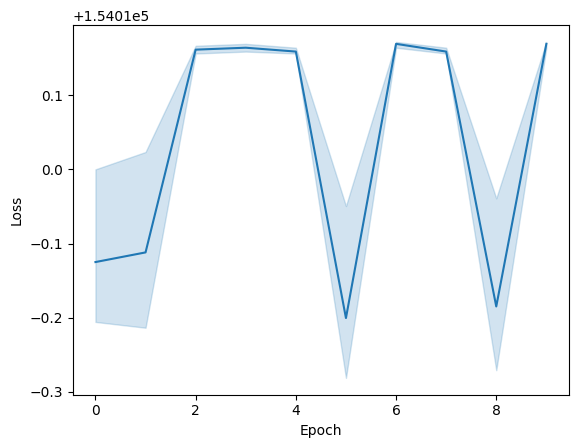

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_losses = pd.DataFrame(train_losses, columns=["Epoch", "Loss"])
test_losses = pd.DataFrame(test_losses, columns=["Epoch", "Loss"])

sns.lineplot(data=train_losses, x="Epoch", y="Loss")
plt.show()
